# Tugas Besar Big Data
[here](https://www.kaggle.com/datasets/jocelyndumlao/prdect-id-indonesian-emotion-classification)


In [1]:
# %pip install pandas
# %pip install scikit-learn
# %pip install matplotlib
# %pip install seaborn
# %pip install nltk
# %pip install gensim
# %pip install keras
# %pip install scipy==1.10.1
# %pip install sastrawi



In [2]:

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import pandas as pd
import numpy as np
import re
import string
import gensim
import nltk
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from keras.callbacks import EarlyStopping
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.optimizers import Adam


from keras.utils import to_categorical
from keras.backend import clear_session

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
data = pd.read_csv("PRDECT-ID Dataset.csv")
data.head()

,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion
0,Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Alhamdulillah berfungsi dengan baik. Packaging...,Positive,Happy
1,Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,"barang bagus dan respon cepat, harga bersaing ...",Positive,Happy
2,Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,"barang bagus, berfungsi dengan baik, seler ram...",Positive,Happy
3,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,bagus sesuai harapan penjual nya juga ramah. t...,Positive,Happy
4,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive,Happy


In [5]:
data = data.drop_duplicates()
data = data.dropna()
factory = StopWordRemoverFactory()
stop_words = factory.get_stop_words()

In [6]:
columns_to_drop = ['Category', 'Product Name', 'Location', 'Price', 'Overall Rating', 'Number Sold', 'Total Review', 'Customer Rating', 'Emotion']
data = data.drop(columns=columns_to_drop)

In [7]:
print(data.head())

                                     Customer Review Sentiment
0  Alhamdulillah berfungsi dengan baik. Packaging...  Positive
1  barang bagus dan respon cepat, harga bersaing ...  Positive
2  barang bagus, berfungsi dengan baik, seler ram...  Positive
3  bagus sesuai harapan penjual nya juga ramah. t...  Positive
4  Barang Bagus, pengemasan Aman, dapat Berfungsi...  Positive


In [8]:
def preprocess_text(review):
    review = re.sub("\S*\d\S*", "", review).strip()
    review = re.sub('[^A-Za-z]+', ' ', review)
    review = review.translate(str.maketrans("","",string.punctuation))
    review = word_tokenize(review)
    review = [word for word in review if word.lower() not in stop_words]
    review = " ".join(review)
    review.strip()
    return review

data['Customer Review'] = data['Customer Review'].apply(lambda x: preprocess_text(x))
data.head()

,Customer Review,Sentiment
0,Alhamdulillah berfungsi baik Packaging aman Re...,Positive
1,barang bagus respon cepat harga bersaing yg,Positive
2,barang bagus berfungsi baik seler ramah pengir...,Positive
3,bagus sesuai harapan penjual nya ramah trimaka...,Positive
4,Barang Bagus pengemasan Aman Berfungsi Baik,Positive


In [9]:
le = LabelEncoder()
label = le.fit_transform(data['Sentiment'])
data['Sentiment'] = label

X = data['Customer Review']
y = to_categorical(data['Sentiment'],num_classes=2)
print(y.shape)

(5393, 2)


# LSTM

In [10]:
max_features = 2500
MAX_SEQUENCE_LENGTH = 50

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index
print("Found %s unique tokens" % len(word_index),'\n')
print("Index: "+str(tokenizer.word_index),"\n")

X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating="post")

Found 8270 unique tokens 

Index: {'barang': 1, 'yg': 2, 'sesuai': 3, 'nya': 4, 'bagus': 5, 'cepat': 6, 'ga': 7, 'pengiriman': 8, 'beli': 9, 'banget': 10, 'seller': 11, 'produk': 12, 'sangat': 13, 'gak': 14, 'baik': 15, 'kecewa': 16, 'dikirim': 17, 'aman': 18, 'harga': 19, 'pesanan': 20, 'respon': 21, 'packing': 22, 'sama': 23, 'kualitas': 24, 'rapi': 25, 'baru': 26, 'terima': 27, 'barangnya': 28, 'kurang': 29, 'sekali': 30, 'toko': 31, 'kasih': 32, 'mau': 33, 'lama': 34, 'jadi': 35, 'warna': 36, 'rusak': 37, 'buat': 38, 'penjual': 39, 'udah': 40, 'berfungsi': 41, 'aja': 42, 'kirim': 43, 'mantap': 44, 'tp': 45, 'padahal': 46, 'deskripsi': 47, 'pas': 48, 'bahan': 49, 'tdk': 50, 'dipakai': 51, 'proses': 52, 'bgt': 53, 'cuma': 54, 'packaging': 55, 'lebih': 56, 'bahannya': 57, 'pesan': 58, 'disini': 59, 'order': 60, 'pake': 61, 'ternyata': 62, 'banyak': 63, 'sy': 64, 'hari': 65, 'kali': 66, 'semoga': 67, 'pakai': 68, 'ramah': 69, 'murah': 70, 'nyaman': 71, 'malah': 72, 'tipis': 73, 'recomm

In [11]:
id_w2v = gensim.models.word2vec.Word2Vec.load("model/idwiki_word2vec_300.model")
id_w2v.wv['harus']

array([ 1.91825211e+00, -1.05259156e+00,  6.82873368e-01, -7.91065812e-01,
       -1.06059468e+00, -2.05891633e+00,  4.02761793e+00,  1.88632786e-01,
       -1.40470719e+00,  9.23173279e-02,  1.81042421e+00,  1.87745976e+00,
       -1.51059401e+00,  7.12196887e-01, -1.83491695e+00,  9.73345935e-01,
       -7.75236130e-01,  1.89067411e+00,  1.22218561e+00, -6.29127204e-01,
       -8.12841654e-01, -1.92935920e+00, -8.01004231e-01,  2.29787517e+00,
        1.95812607e+00, -2.04547620e+00, -1.86424506e+00,  1.97986588e-01,
       -1.00040627e+00,  4.41855550e-01, -1.98604953e+00, -2.06735685e-01,
        1.28696764e+00, -2.34551668e+00,  5.31671286e-01,  9.69078720e-01,
        1.77530813e+00,  2.20860505e+00,  1.21989584e+00, -4.88584137e+00,
        1.80886555e+00,  6.69352114e-01,  7.40300536e-01, -3.21869516e+00,
       -1.06191874e+00, -6.34010434e-01, -1.77901614e+00,  1.45590520e+00,
        1.76141179e+00,  5.30128002e-01,  2.76071262e+00,  1.77319992e+00,
        5.39274216e-02,  

In [12]:
print(id_w2v.wv.most_similar('bagus'))
w2v_weights = id_w2v.wv.vectors

[('mumpuni', 0.5796131491661072), ('menggembirakan', 0.5630608201026917), ('mengagumkan', 0.5339281558990479), ('memadai', 0.5302690267562866), ('mengesankan', 0.5253195762634277), ('baik', 0.5235913395881653), ('impresif', 0.5224843621253967), ('memuaskan', 0.5186058878898621), ('jelek', 0.516669511795044), ('minim', 0.5104171633720398)]


In [13]:
vocab_size, embedding_size = w2v_weights.shape
print("Size Kamus: {} - Dimensi Embedding: {}".format(vocab_size, embedding_size))

Size Kamus: 331792 - Dimensi Embedding: 300


In [14]:
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_size,
                    trainable=False))
model.add(LSTM(embedding_size, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'))
model.add(LSTM(embedding_size, return_sequences=False, activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(2,activation='sigmoid'))


# early_stop = EarlyStopping(monitor="val_loss",patience=10,verbose=True)

In [15]:
batch_size = 64
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
result = []
with strategy.scope():
    model.compile(loss = 'binary_crossentropy', optimizer=Adam(learning_rate=0.01),metrics = ["accuracy"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
    history = model.fit(X_train, y_train, epochs=75, validation_data=(X_test, y_test), verbose = 1)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print("\n",classification_report(y_true, y_pred))

Epoch 1/75
135/135 ━━━━━━━━━━━━━━━━━━━━ 39s 111ms/step - accuracy: 0.5150 - loss: 0.7390 - val_accuracy: 0.5144 - val_loss: 0.7146
Epoch 2/75
135/135 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.5312 - loss: 0.6969 - val_accuracy: 0.5209 - val_loss: 0.7260
Epoch 3/75
135/135 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.7760 - loss: 0.5219 - val_accuracy: 0.8860 - val_loss: 0.3211
Epoch 4/75
135/135 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.8979 - loss: 0.3038 - val_accuracy: 0.8888 - val_loss: 0.3076
Epoch 5/75
135/135 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.9208 - loss: 0.2416 - val_accuracy: 0.9082 - val_loss: 0.2565
Epoch 6/75
135/135 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.9335 - loss: 0.1917 - val_accuracy: 0.8981 - val_loss: 0.2910
Epoch 7/75
135/135 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.9501 - loss: 0.1656 - val_accuracy: 0.9166 - val_loss: 0.2498
Epoch 8/75
135/135 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.9456 - loss: 0

KeyboardInterrupt: 

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 300)        │    99,537,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 300)        │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 300)            │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           602 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 302,941,808 (1.13 GB)

 Trainable params: 100,980,602 (385.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 201,961,206 (770.42 MB)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


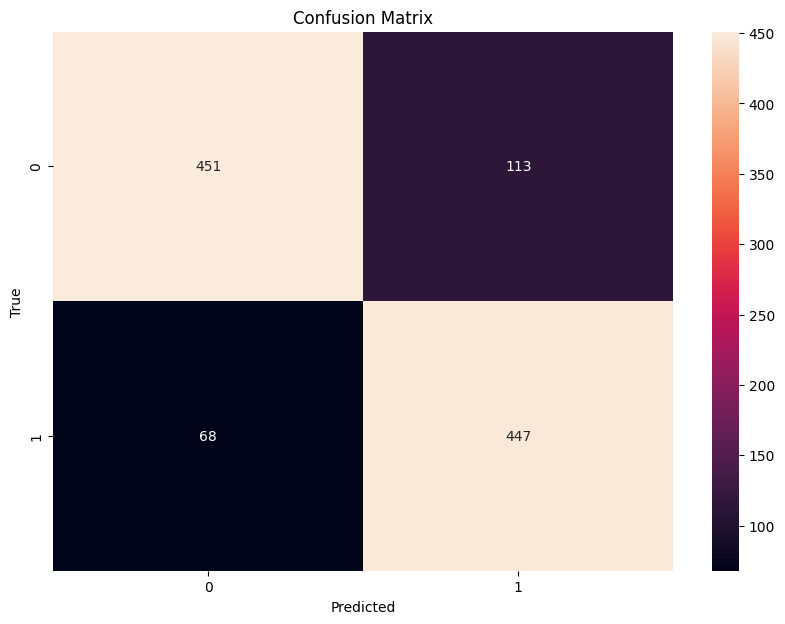

In [ ]:
y_pred_probs = model.predict(X_test)

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()